# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

### 55 PyTorch Convolutional Nerual Network (CNN) classifier for Numer.Ai Binary Classification problem using CONV1D (one dimentional convolution). 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


### Data
- Download from https://numer.ai/leaderboard

<img src="../images/Numerai.png" width="35%" align="center">

# Why are we doing this? 

## One dimetional CNN? Convolutional Nerual Network (CNN) using one dimentional convolution (CONV1D).

- Indeed, most of the existing PyTorch examples are using Images, while here we have a CSV with 21 features. Using CONV1D *before or after a Lineer layer* requires the use of **reshaping**, and this is the **whole point of this tutorial**. 

- Thus, the CNN architecture is naive and by no means **optimized**. Hopefully, I will improve it over time and I am working on a second CNN based version of the same problem. 


## Introduction

- This tutorial was written in order to demonstrate a **fully working** example of a PyTorch **CNN** on a real world use case, namely a Binary Classification problem. 

- If you are interested in the sk-learn version of this problem please refer to: https://github.com/QuantScientist/deep-ml-meetups/tree/master/hacking-kaggle/python/numer-ai 

- For the scientific foundation behind Binary Classification and Logistic Regression, refer to: https://github.com/QuantScientist/Deep-Learning-Boot-Camp/tree/master/Data-Science-Interviews-Book

- Every step, from reading the CSV into numpy arrays, converting to GPU based tensors, training and validation, are meant to aid newcomers in their first steps in PyTorch. 

- Additionally, commonly used Kaggle metrics such as ROC_AUC and LOG_LOSS are logged and plotted both for the training set as well as for the validation set. 

# PyTorch Imports


In [2]:
# !pip install pycuda
%reset -f

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)

handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil

import torch
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
memReport()

# %%timeit
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor


use_cuda=False
lgr.info("USE CUDA=" + str (use_cuda))

tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0+42448cf
__CUDA VERSION
__CUDNN VERSION: None
__Number CUDA Devices: 1
__Devices
OS:  linux2
Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
PyTorch:  0.2.0+42448cf
Numpy:  1.13.1
2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
14.9
svmem(total=67469099008, available=63826079744, percent=5.4, used=3081224192, free=61383819264, active=4334473216, inactive=1083142144, buffers=304386048, cached=2699669504, shared=12570624)
memory GB: 0.26350402832


INFO:__main__:USE CUDA=False


#  Global params

In [3]:
# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)    

#  View the Data
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [4]:
# Data params
TARGET_VAR= 'target'
TOURNAMENT_DATA_CSV = 'numerai_tournament_data.csv'
TRAINING_DATA_CSV = 'numerai_training_data.csv'
BASE_FOLDER = 'numerai/'

df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
df_train.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
0,805942eb33874b8a,era1,train,0.30008,0.37324,0.57645,0.37148,0.52052,0.60583,0.33377,...,0.47933,0.58084,0.42970,0.45649,0.60583,0.72200,0.50618,0.48407,0.50080,0
1,5b7677d6dd4a4628,era1,train,0.56470,0.70196,0.48211,0.62086,0.62108,0.45080,0.53855,...,0.46720,0.49887,0.75146,0.29838,0.60046,0.39081,0.56075,0.66980,0.54756,0
2,d07e9a5554ce4260,era1,train,0.43007,0.66582,0.49114,0.47834,0.58221,0.56852,0.31707,...,0.47799,0.53493,0.62822,0.33925,0.50770,0.37361,0.64351,0.44245,0.46482,0
3,edb288460914446b,era1,train,0.45063,0.41458,0.45002,0.45682,0.51356,0.30201,0.58351,...,0.50967,0.52020,0.53748,0.65659,0.42574,0.55174,0.45375,0.53443,0.41326,0
4,71c393405b0f4835,era1,train,0.32543,0.29692,0.62043,0.50293,0.53586,0.63649,0.23866,...,0.48918,0.60177,0.48885,0.47384,0.45593,0.59715,0.60360,0.41422,0.41210,1


#  Train / Validation / Test Split
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.decomposition import PCA

def toPCA(X_X, n=16):
    pca = PCA(n_components=n)
    pca.fit(X_X)
    X_reduced = pca.transform(X_X)
    print("Reduced dataset shape:", X_reduced.shape)
    return X_reduced

def addPolyFeatures(inDF, deg=2):
    print('Generating poly features ...')
    df_copy=inDF.copy(deep=True)
    poly=PolynomialFeatures(degree=deg)
    p_testX = poly.fit(df_copy)
    # AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_copy.columns,p) for p in poly.powers_]]
    df_copy = pd.DataFrame(p_testX.transform(df_copy),columns=target_feature_names)
        
    return df_copy

# Train, Validation, Test Split
def loadDataSplit(poly=False):
    df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    df_test_valid = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)

    answers_1_SINGLE = df_train[TARGET_VAR]
    df_train.drop(TARGET_VAR, axis=1,inplace=True)
    df_train.drop('id', axis=1,inplace=True)
    df_train.drop('era', axis=1,inplace=True)
    df_train.drop('data_type', axis=1,inplace=True)    
    
    # Add polynomial features
    if poly:
        df_train = addPolyFeatures(df_train)

    df_train.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=False,  index = False)    
    df_train= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=None, dtype=np.float32)    
    df_train = pd.concat([df_train, answers_1_SINGLE], axis=1)
    feature_cols = list(df_train.columns[:-1])
#     print (feature_cols)
    target_col = df_train.columns[-1]
    trainX, trainY = df_train[feature_cols], df_train[target_col]
    
    
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    # Validation set
    df_validation_set=df_test_valid.loc[df_test_valid['data_type'] == 'validation'] 
    df_validation_set=df_validation_set.copy(deep=True)
    answers_1_SINGLE_validation = df_validation_set[TARGET_VAR]
    df_validation_set.drop(TARGET_VAR, axis=1,inplace=True)    
    df_validation_set.drop('id', axis=1,inplace=True)
    df_validation_set.drop('era', axis=1,inplace=True)
    df_validation_set.drop('data_type', axis=1,inplace=True)
    
   # Add polynomial features    
    if poly:
        df_validation_set = addPolyFeatures(df_validation_set)
    
    df_validation_set.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=False,  index = False)    
    df_validation_set= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=None, dtype=np.float32)    
    df_validation_set = pd.concat([df_validation_set, answers_1_SINGLE_validation], axis=1)
    feature_cols = list(df_validation_set.columns[:-1])

    target_col = df_validation_set.columns[-1]
    valX, valY = df_validation_set[feature_cols], df_validation_set[target_col]
                            
    # Test set for submission (not labeled)    
    df_test_set = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)
#     df_test_set=df_test_set.loc[df_test_valid['data_type'] == 'live'] 
    df_test_set=df_test_set.copy(deep=True)
    df_test_set.drop(TARGET_VAR, axis=1,inplace=True)
    tid_1_SINGLE = df_test_set['id']
    df_test_set.drop('id', axis=1,inplace=True)
    df_test_set.drop('era', axis=1,inplace=True)
    df_test_set.drop('data_type', axis=1,inplace=True)   
    
    # Add polynomial features 
    if poly:
        df_test_set = addPolyFeatures(df_test_set)
       
    feature_cols = list(df_test_set.columns) # must be run here, we dont want the ID    

    df_test_set = pd.concat([tid_1_SINGLE, df_test_set], axis=1)            
    testX = df_test_set[feature_cols].values
        
    return trainX, trainY, valX, valY, testX, df_test_set


trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()

In [6]:
print (trainX.shape)
print (trainY.shape)
print (valX.shape)
print (valY.shape)
print (testX.shape)
print (df_test_set.shape)

# trainX=toPCA(trainX)
# valX=toPCA(valX)
# testX=toPCA(testX)

# # Number of features for the input layer
N_FEATURES=trainX.shape[1]

(535713, 50)
(535713,)
(73865, 50)
(73865,)
(349053, 50)
(349053, 51)


#  From Numpy to PyTorch GPU tensors

In [7]:
# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def XnumpyToTensor(x_data_np):
    x_data_np = np.array(x_data_np, dtype=np.float32)        
    print(x_data_np.shape)
    print(type(x_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")    
        X_tensor = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        lgr.info ("Using the CPU")
        X_tensor = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    
    print(type(X_tensor.data)) # should be 'torch.cuda.FloatTensor'            
    print((X_tensor.data.shape)) # torch.Size([108405, 29])
    return X_tensor


# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def YnumpyToTensor(y_data_np):    
    y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!
    print(y_data_np.shape)
    print(type(y_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")            
    #     Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor).cuda()  # BCEloss requires Float        
    else:
        lgr.info ("Using the CPU")        
    #     Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor)  # BCEloss requires Float        

    print(type(Y_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(y_data_np.shape)
    print(type(y_data_np))    
    return Y_tensor

# CNN Architecture


# How conv1d works? 

- conv = torch.nn.Conv1d(in_channels=5, out_channels=10, kernel_size=2)

- Note that view is only supposed to work on contiguous tensors, and transposing a tensor makes it non-contiguous. You can use .contiguous() after transpose 

- Note that Conv1d expects (batch, in_channels, in_length).

# Can we learn from the AlexNet architecture? 

In [8]:
import torchvision.models as models
alexnet = models.alexnet(pretrained = False) # set False so that it is not downloaded
print(alexnet)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


In [9]:
# n_input n_cnn_kernel n_padding n_input_rows n_hidden     after CNN                      stride
# 21      1            1         108405       21*32=672    torch.Size([108405, 672, 3]    1
# 21      1            2         108405       21*32=672    torch.Size([108405, 672, 5]    
# 21      1            3         108405       21*32=672    torch.Size([108405, 672, 7]
# 21      1            4         108405       21*32=672    torch.Size([108405, 672, 9]

# 21      2            1         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      3            1         108405       21*32=672    torch.Size([108405, 672, 1]
# 21      4            1         108405       21*32=672    ERROR * ERROR * ERROR 
# Given input size: (21 x 1 x 1). 
# Calculated output size: (672 x 1 x 0). Output size is too small 

# 21      2            2         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      3            2         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      4            2         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      5            2         108405       21*32=672    torch.Size([108405, 672, 1]
# 21      6            2         108405       21*32=672    ERROR * ERROR * ERROR

# 21      1            3         108405       21*32=672    torch.Size([108405, 672, 7]
# 21      2            3         108405       21*32=672    torch.Size([108405, 672, 6]
# 21      3            3         108405       21*32=672    torch.Size([108405, 672, 5]
# 21      4            3         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      5            3         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      6            3         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      7            3         108405       21*32=672    torch.Size([108405, 672, 1]


# 21      4            4         108405       21*32=672    torch.Size([108405, 672, 6]
# 21      5            4         108405       21*32=672    torch.Size([108405, 672, 5]
# 21      6            4         108405       21*32=672    torch.Size([108405, 672, 4]
# 21      7            4         108405       21*32=672    torch.Size([108405, 672, 3]
# 21      8            4         108405       21*32=672    torch.Size([108405, 672, 2]
# 21      9            4         108405       21*32=672    torch.Size([108405, 672, 1]


# 21      4            4         108405       21*32=672    torch.Size([108405, 672, 3]   2
# 21      5            4         108405       21*32=672    torch.Size([108405, 672, 3]   2
# 21      6            4         108405       21*32=672    torch.Size([108405, 672, 2]   2



In [10]:
loss_func=torch.nn.BCELoss() # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
# References:
# https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/5_convolutional_net.py
# https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556

X_tensor_train= XnumpyToTensor(trainX) # default order is NBC for a 3d tensor, but we have a 2d tensor
X_shape=X_tensor_train.data.size()

# 21      6            3         108405       21*32=672    torch.Size([108405, 672, 2] n_max_pool1d=1

n_mult_factor=3
n_input= trainX.shape[1]
n_hidden= n_input * n_mult_factor
n_output=1
n_input_rows=trainX.shape[0]
n_cnn_kernel=3
n_padding=2

n_max_pool1d=2

DEBUG_ON=True
def debug(msg, x):
    if DEBUG_ON:
        print (msg + ', (size():' + str (x.size()))
    
class CNNNumerAI(nn.Module):    
    def __init__(self, n_input, n_hidden, n_output,n_cnn_kernel, n_mult_factor, n_padding,n_max_pool1d):
        super(CNNNumerAI, self).__init__()    
        self.n_input=n_input
        self.n_hidden=n_hidden
        self.n_output= n_output 
        self.n_cnn_kernel=n_cnn_kernel
        self.n_mult_factor=n_mult_factor
        self.n_padding=n_padding
        self.n_max_pool1d=n_max_pool1d
        self.n_l1=int((n_mult_factor * self.n_input) * (n_padding + 1) / n_max_pool1d)
                    
        self.features = nn.Sequential( # Mimicking AlexNet 
            torch.nn.Conv1d(self.n_input, self.n_hidden,kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(self.n_padding,)),                                             
            torch.nn.LeakyReLU(),            
            torch.nn.MaxPool1d(kernel_size=self.n_max_pool1d),
            
            torch.nn.Conv1d(self.n_hidden,self.n_hidden,kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(self.n_padding,)),                                             
            torch.nn.ReLU(),            
            torch.nn.MaxPool1d(kernel_size=self.n_max_pool1d),
                        
        )                                         
        self.fc3 = torch.nn.Linear(int(self.n_hidden),self.n_output, bias=True)
        torch.nn.init.xavier_uniform(self.fc3.weight,gain=np.sqrt(2.0))        
                
        self.classifier = nn.Sequential(            
            self.fc3,
        )                                 
        self.sig=nn.Sigmoid()
                
        
    def forward(self, x):
#         debug('raw',x)   
        varSize=x.data.shape[0] # must be calculated here in forward() since its is a dynamic size                          
        # for CNN  
        x=x.contiguous() 
        x = x.view(varSize,self.n_input,1)
        debug('after view',x)   
        x=self.features(x)
        debug('after CNN',x)   
        # for Linear layer
#         x = x.view(varSize,self.n_l1) 
        x = x.view(varSize,int(self.n_hidden)) 
        debug('after 2nd view',x)                  
        x=self.classifier(x)   
        debug('after self.out',x)   
        x=self.sig(x)
        return x

net = CNNNumerAI(n_input, n_hidden, n_output,n_cnn_kernel, n_mult_factor, n_padding, n_max_pool1d)    
lgr.info(net)

if use_cuda:
    net=net.cuda() 
b = net(X_tensor_train)

print ('(b.size():' + str (b.size())) 

INFO:__main__:Using the CPU
INFO:__main__:CNNNumerAI (
  (features): Sequential (
    (0): Conv1d(50, 150, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): LeakyReLU (0.01)
    (2): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc3): Linear (150 -> 1)
  (classifier): Sequential (
    (0): Linear (150 -> 1)
  )
  (sig): Sigmoid ()
)


(535713, 50)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([535713, 50])
after view, (size():torch.Size([535713, 50, 1])
after CNN, (size():torch.Size([535713, 150, 1])
after 2nd view, (size():torch.Size([535713, 150])
after self.out, (size():torch.Size([535713, 1])
(b.size():torch.Size([535713, 1])


In [11]:
# NN params
LR = 0.005
MOMENTUM= 0.9

# optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=5e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=LR,weight_decay=5e-5) #  L2 regularization
if use_cuda:
    lgr.info ("Using the GPU")    
    net.cuda()
    loss_func.cuda()

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:<torch.optim.adam.Adam object at 0x7fe4281e3fd0>
INFO:__main__:BCELoss (
)


# Training set

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(535713, 50)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([535713, 50])
(535713, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(535713, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
0 [ 0.6922484]
EP: 29.950 seconds
LOG_LOSS=0.692224896679, ROC_AUC=0.525582739983 
10 [ 0.69210666]
EP: 28.364 seconds
LOG_LOSS=0.69208558122, ROC_AUC=0.526033332525 
20 [ 0.69202733]
EP: 28.453 seconds
LOG_LOSS=0.692046407709, ROC_AUC=0.526328676717 
30 [ 0.69201744]
EP: 28.998 seconds
LOG_LOSS=0.6920158641, ROC_AUC=0.526562810898 
40 [ 0.69199985]
EP: 30.263 seconds
LOG_LOSS=0.692000448927, ROC_AUC=0.526745774694 
50 [ 0.69198549]
EP: 29.482 seconds
LOG_LOSS=0.691986868569, ROC_AUC=0.526892076034 
60 [ 0.69197893]
EP: 29.170 seconds
LOG_LOSS=0.691976443951, ROC_AUC=0.527017594675 
70 [ 0.69196975]
EP: 28.988 seconds
LOG_LOSS=0.69196681183, ROC_AUC=0.527128927015 
80 [ 0.69195348]
EP: 29.064 seconds
LOG_LOSS=0.691957429379, ROC_AUC=0.527235251537

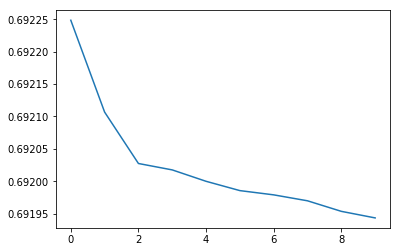

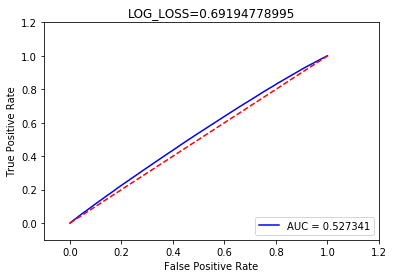

In [14]:
import time
start_time = time.time()    
epochs=100
all_losses = []

DEBUG_ON=False

X_tensor_train= XnumpyToTensor(trainX)
Y_tensor_train= YnumpyToTensor(trainY)

print(type(X_tensor_train.data), type(Y_tensor_train.data)) # should be 'torch.cuda.FloatTensor'

# From here onwards, we must only use PyTorch Tensors
for step in range(epochs):
    epoch_start_time = time.time()    
    out = net(X_tensor_train)                 # input x and predict based on x
    cost = loss_func(out, Y_tensor_train)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
                           
    if step % 10 == 0:        
        loss = cost.data[0]
        all_losses.append(loss)
        print(step, cost.data.cpu().numpy())        
        prediction = (net(X_tensor_train).data).float() # probabilities             
        pred_y = prediction.cpu().numpy().squeeze()
        target_y = Y_tensor_train.cpu().data.numpy()                        
        tu = (log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        epoch_end_time = time.time()
        print ('{} {:6.3f} seconds'.format('EP:', epoch_end_time-epoch_start_time))
        print ('LOG_LOSS={}, ROC_AUC={} '.format(*tu))        
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Validation set + ROC_AUC

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(73865, 50)
(73865,)
(73865, 50)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
torch.Size([73865, 50])
(73865, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(73865, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


acc=0.0 log_loss=0.692318498129 roc_auc=0.522010646113 


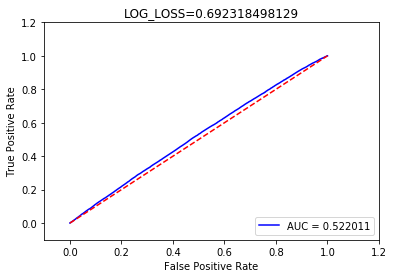

In [16]:
net.eval()
# Validation data
print (valX.shape)
print (valY.shape)

X_tensor_val= XnumpyToTensor(valX)
Y_tensor_val= YnumpyToTensor(valY)


print(type(X_tensor_val.data), type(Y_tensor_val.data)) # should be 'torch.cuda.FloatTensor'

predicted_val = (net(X_tensor_val).data).float() # probabilities 
# predicted_val = (net(X_tensor_val).data > 0.5).float() # zero or one
pred_y = predicted_val.cpu().numpy()
target_y = Y_tensor_val.cpu().data.numpy()                

print (type(pred_y))
print (type(target_y))

tu = (str ((pred_y == target_y).mean()),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('\n')
print ('acc={} log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print (pred_y)

# Test set + Submission file for Numerai

In [18]:
print (df_test_set.shape)
columns = ['id', 'probability']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
df_pred.id.astype(int)

for index, row in df_test_set.iterrows():
    rwo_no_id=row.drop('id')    
#     print (rwo_no_id.values)    
    x_data_np = np.array(rwo_no_id.values, dtype=np.float32)        
    if use_cuda:
        X_tensor_test = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        X_tensor_test = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
                    
    X_tensor_test=X_tensor_test.view(1, trainX.shape[1]) # does not work with 1d tensors            
    predicted_val = (net(X_tensor_test).data).float() # probabilities     
    p_test =   predicted_val.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    df_pred = df_pred.append({'id':row['id'], 'probability':p_test},ignore_index=True)
    
df_pred.head(5)

(349053, 51)


,id,probability
0,9403af5f3de44039,0.500493
1,67d84c8e966047d9,0.519539
2,12f1aa03af504e19,0.482264
3,e003f1be931040fa,0.499577
4,550cac2470fe4644,0.493192


In [19]:
# df_pred.id=df_pred.id.astype(int)

def savePred(df_pred, loss):
#     csv_path = 'pred/p_{}_{}_{}.csv'.format(loss, name, (str(time.time())))
    csv_path = 'pred/pred_{}_{}.csv'.format(loss, (str(time.time())))
    df_pred.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print (csv_path)
    
savePred (df_pred, log_loss(target_y, pred_y))

pred/pred_0.692318498129_1505566614.61.csv
